# Projeto 1
## [NLP] Análise de sentimento sobre o mercado financeiro
Estudante: João Rodrigues

### Abra o Projeto no Colab!
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/joaodath/trilha_dados/blob/main/mod_3/projeto03/projeto03.ipynb)

In [ ]:
# instalação dos pacotes necessários na versão mais nova
%pip install -U scikit-learn pandas numpy seaborn spacy --quiet

#preparing spacy, hang on we're downloading over 400MB of data :)
%pip install "https://github.com/explosion/spacy-models/releases/download/en_core_web_lg-3.3.0/en_core_web_lg-3.3.0-py3-none-any.whl" --quiet


In [110]:
import numpy as np
import pandas as pd

import spacy
from spacy.tokens import Span

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.pipeline import Pipeline

#estimators
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
import lightgbm as lgb

#graphs
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
# # aqui a gente cala a boca do sklearn
# # importa o filtro
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning, UndefinedMetricWarning


# # monta o filtro
simplefilter("ignore", category=ConvergenceWarning)
simplefilter("ignore", category=UndefinedMetricWarning)

In [3]:
def multi_classifier_fit_score(cleaner, vectorizer, classifiers: dict, X, y) -> dict:
  """
  Fit and Test multiple classifiers at the same time
  Returns a dictonary of scores and a dictionary of all fitted pipelines accessable by the key of the classifiers' dict

  Arguments:
    cleaner: a pipeline-ready object to clean data
    vectorizer: a pipeline-ready object to vectorize the data
    classifiers: a dictionary of classifiers to fit and score {'estimator_name': estimator()}
    X: features that explain the target
    y: target
  
  Returns:
    scores(dict): a dictionary where keys are the classifiers' names inside the classifiers dict and the values are lists
      with accuracy, precision and recall scores.
    models(dict): a dictionary where the keys are the classifiers' names inside the classifiers dict and the values are 
      all the models fitted by this function
  """
  from sklearn.metrics import accuracy_score, precision_score, recall_score
  from sklearn.model_selection import train_test_split

  scores = {}
  models = {}

  X_train_mcfs, X_test_mcfs, y_train_mcfs, y_test_mcfs = train_test_split(X, y, test_size=0.3, random_state=10)

  for index, classifier in enumerate(classifiers):
    classifier_ready = classifiers[classifier]
  
    pipe_multi_classifier = Pipeline(
    steps=[('cleaner', cleaner),
          ('vectorizer', vectorizer),
          ('classifier', classifier_ready)]
    )

    pipe_multi_classifier.fit(X_train_mcfs, y_train_mcfs)
    
    y_pred_mcfs = pipe_multi_classifier.predict(X_test_mcfs)
    
    scores[classifier] = [
      (round(accuracy_score(y_test_mcfs, y_pred_mcfs), 3)), 
      (round(precision_score(y_test_mcfs, y_pred_mcfs, average='weighted'), 3)), 
      (round(recall_score(y_test_mcfs, y_pred_mcfs, average='weighted'), 3))
    ]

    models[classifier] = pipe_multi_classifier
  
  return scores, models

In [4]:
def best_model(scores: dict, metric: str = 'accuracy') -> list:
  """
  Checks a dictionary of estimators scores and return a list containing the best model
  
  Arguments:
    scores: {'estimator': [accuracy, precision, recall]}
    metric: accuracy | precision | recall
  
  Returns:
    list['estimator', 'score', 'metric']
  """
  metrics_dict = {
    'accuracy': 0,
    'precision': 1,
    'recall': 2
  }

  if metric not in metrics_dict.keys():
    metric = 'accuracy'
  
  position = metrics_dict[metric]
  
  melhor_modelo = []

  for name, score in scores.items():
    if len(melhor_modelo) == 0:
      melhor_modelo = [name, score[position]]
    
    if (score[position] >= melhor_modelo[1]):
      melhor_modelo = [name, score[position]]
  
  melhor_modelo.append(metric)
  return melhor_modelo

In [5]:
nlp = spacy.load('en_core_web_lg')

#### 1. Construa as funções e a pipeline, separe os dados em treino e teste, execute a pipeline para classificar em positivo, negativo e neutro. Quais foram os valores de acurácia, precisão e sensitividade deste modelo? (3.0 pontos)

In [6]:
# Esta funcao remove espacos em branco no inicio e
# no fim do texto e converte todo o texto em letras
# minusculas
def clean_text(texto):     
    return texto.strip().lower()

# Criamos uma classe para gerenciar X e y
class predictors(): #não faz diferença essa herança do TransformerMixin
    def transform(self, X, **transform_params):
        return [clean_text(text) for text in X]
    def fit(self, X, y=None, **fit_params):
        return self
    def get_params(self, deep=True):
        return {}

# Esta funcao remove todas as stopwords e pontuacoes
def tokenizer(texto):
    doc = nlp(texto)
    tokens = [token for token in doc if ((not token.is_stop) & (not token.is_punct))]
    tokens = [token.lemma_.lower().strip() for token in tokens]
    return tokens

# Criamos um objeto CountVectorizer para vetorizar cada
# texto
vectorizer = CountVectorizer(tokenizer = tokenizer, ngram_range=(1,1), dtype=np.float64)

In [7]:
financial = pd.read_csv('https://github.com/joaodath/trilha_dados/raw/main/mod_3/projeto03/data.csv')
financial.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [8]:
# Separando em X e y
X = financial.Sentence
y = financial.Sentiment

# Separando em teste e treino
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
classifiers = {
              'LGBM': lgb.LGBMClassifier(n_estimators=100, random_state=42), 
              'SVC': SVC(random_state=42), 
              'RandomForest': RandomForestClassifier(random_state=42), 
              'AdaBoost': AdaBoostClassifier(DecisionTreeClassifier(random_state=42), n_estimators=100, random_state=42),
              'LogisticRegression': LogisticRegressionCV(cv=5, solver='sag', random_state=42, n_jobs=-1),
              'GradientBoosting': GradientBoostingClassifier(random_state=42)
              }


In [12]:
scores, models = multi_classifier_fit_score(cleaner= predictors(), vectorizer= vectorizer, classifiers=classifiers, X = financial.Sentence, y = financial.Sentiment)

scores

{'LGBM': [0.674, 0.659, 0.674],
 'SVC': [0.674, 0.65, 0.674],
 'RandomForest': [0.673, 0.655, 0.673],
 'AdaBoost': [0.658, 0.657, 0.658],
 'LogisticRegression': [0.682, 0.668, 0.682],
 'GradientBoosting': [0.693, 0.679, 0.693]}

In [13]:
melhor_modelo = best_model(scores, metric='accuracy')
melhor_modelo

['GradientBoosting', 0.693, 'accuracy']

In [14]:
acc = scores['GradientBoosting'][0]
prec = scores['GradientBoosting'][1]
rec = scores['GradientBoosting'][2]

print(f'''
The best model was {melhor_modelo[0]}
Scoring:
Accuracy: {acc}
Precision: {prec}
Recall: {rec}
''')



The best model was GradientBoosting
Scoring:
Accuracy: 0.693
Precision: 0.679
Recall: 0.693



#### 2. Use o seu modelo para classificar os seguintes textos extraídos do site Financial Times. Faça uma tabela com o valor esperado e o valor obtido, e responda: houve divergência entre o esperado e o obtido? O que poderia ser feito para corrigir? (1.0 ponto)

In [15]:
new_data_dict = {
                  "Sentence": ["Central banks’ rate rises, geopolitical risk and slowing growth trigger investors’ stampede for safety.",
                          "China opens up bond market in bid to woo foreign investors.",
                          "HM Revenue & Customs says residents had £850bn in accounts overseas but it does not estimate if tax paid on this.",
                          "Japan’s horrifying crop of data falsification is also encouraging. The scandals have emerged from a distinct new phase in the evolution of the country’s shareholder capitalism.",
                          "Despite internal problems, the group continues to exert a tight grip on the US’s gun control debate."],
                  "Sentiment": ["negative", "neutral", "negative", "negative", "neutral"]        
                          }
                          
new_data = pd.DataFrame(new_data_dict)

new_data.head()

,Sentence,Sentiment
0,"Central banks’ rate rises, geopolitical risk a...",negative
1,China opens up bond market in bid to woo forei...,neutral
2,HM Revenue & Customs says residents had £850bn...,negative
3,Japan’s horrifying crop of data falsification ...,negative
4,"Despite internal problems, the group continues...",neutral


In [16]:
models[melhor_modelo[0]]

Pipeline(steps=[('cleaner', <__main__.predictors object at 0x7f770ec1b8e0>),
                ('vectorizer',
                 CountVectorizer(dtype=<class 'numpy.float64'>,
                                 tokenizer=<function tokenizer at 0x7f777d484b80>)),
                ('classifier', GradientBoostingClassifier(random_state=42))])

In [17]:
y_pred2 = models[melhor_modelo[0]].predict(new_data.Sentence)
print(round(accuracy_score(new_data.Sentiment, y_pred2), 3))
print(round(precision_score(new_data.Sentiment, y_pred2, average='macro'), 3))
print(round(recall_score(new_data.Sentiment, y_pred2, average='macro'), 3))

0.4
0.167
0.333


In [18]:
sentences = new_data_dict['Sentence']
sentiments_or = new_data_dict['Sentiment']
sentiments_pred = y_pred2

values_dict = {"Sentence": sentences, "Original Sentiment": sentiments_or, "Predicted Sentiment": sentiments_pred}

values_df = pd.DataFrame(values_dict)

values_df['Divergence'] = values_df["Predicted Sentiment"] != values_df["Original Sentiment"]

values_df

,Sentence,Original Sentiment,Predicted Sentiment,Divergence
0,"Central banks’ rate rises, geopolitical risk a...",negative,positive,True
1,China opens up bond market in bid to woo forei...,neutral,neutral,False
2,HM Revenue & Customs says residents had £850bn...,negative,neutral,True
3,Japan’s horrifying crop of data falsification ...,negative,neutral,True
4,"Despite internal problems, the group continues...",neutral,neutral,False


In [19]:
values_df['Divergence'].value_counts()

True     3
False    2
Name: Divergence, dtype: int64

#### 3. Faça uma análise exploratória, onde identifique as três empresas mais citadas e quantifique os níveis de positividade, negatividade e neutralidade dos textos sobre estas empresas. (3.0 pontos)

##### a. Extraia de todos os textos as entidades, há quantas entidades? (0.6 pontos) 

In [20]:
#testing

entities = 0
for row in range(financial.shape[0]):
  doc = nlp(financial.Sentence[row])
  for ent in doc.ents:
    entities += 1

entities

15408

##### b. Quantas entidades são empresas? (0.6 pontos)

In [54]:
cleaning_list = ['EUR', '65mn', 'Group', 'Location Based Search Technology']
orgs = {'original_index': [], 'entity': [], 'sentiment': []}
for row in range(financial.shape[0]):
  doc = nlp(financial.Sentence[row])
  new_labels = []
  index = -1
  for token in doc:
    index += 1
    if token.text in cleaning_list:
      new_labels.append(Span(doc, index, index+1, label="OTHER"))
      doc.set_ents(new_labels, default="unmodified")
  for ent in doc.ents:
    if ent.label_ == 'ORG':
      orgs['original_index'].append(row)
      orgs['entity'].append(ent.text)
      orgs['sentiment'].append(financial.Sentiment[row])
    

ents = pd.DataFrame(orgs)
ents.head()

,original_index,entity,sentiment
0,0,GeoSolutions,positive
1,0,Location Based Search Technology,positive
2,1,ESI,negative
3,1,BK,negative
4,2,Componenta,positive


In [55]:
ents.entity.shape

(4606,)

##### c. Quais são as três empresas mais citadas? (0.6 pontos)

In [96]:
ents.entity.value_counts()


Nokia                     63
AAPL                      40
Finnair                   29
Tesco                     29
FTSE                      26
                          ..
Top Post                   1
Hillshire Farms            1
ConAgra Names              1
Pioneer Library System     1
Nordic Walking             1
Name: entity, Length: 2664, dtype: int64

##### d. Faça uma tabela onde demonstre as três empresas mais citadas e o total de textos positivos, negativos e neutros de cada uma. (1.2 pontos)

In [120]:
#todo: loop through the ents dataframe, count each positive, negative and neutral sentiment, add them to a list inside a dict
## the return the dict as a new dataframe (may need to flip(?) the axis)

most_quoted = ['Nokia', 'AAPL', 'Finnair']
sentiments = ['neutral', 'negative', 'positive']
total_values = {'neutral': {}, 'negative': {}, 'positive': {}}

for brand in most_quoted:
  df = ents[ents['entity'] == brand]
  df = df.drop('original_index', axis=1)

  for sentiment in sentiments:
    count = df[df['sentiment'] == sentiment].value_counts()
    df_count = pd.DataFrame(count)
    df_count.reset_index(inplace=True)
    df_count.columns = ['entity', 'sentiment', 'count']
    df_count.drop(['entity', 'sentiment'], axis=1, inplace=True)
    total_values[sentiment][brand] = int(df_count['count'].to_string()[1:].strip())
  
total_values = pd.DataFrame(total_values)
total_values.reset_index(inplace=True)
total_values.columns = ['entity', 'neutral', 'negative', 'positive']
total_values

,entity,neutral,negative,positive
0,Nokia,38,5,20
1,AAPL,2,11,27
2,Finnair,12,8,9


#### 4. Faça gráficos a partir da tabela obtida acima. Descreva cada gráfico de forma que estivesse apresentando à diretoria dessas três empresas. (3.0 pontos)

<AxesSubplot:xlabel='entity', ylabel='neutral'>

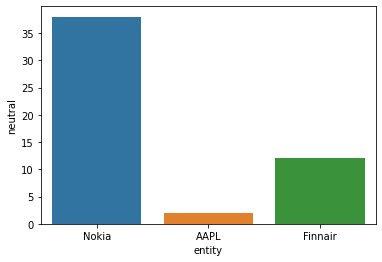

In [121]:
sns.barplot(x='entity', y='neutral', data=total_values)

explicação bonita aqui

<AxesSubplot:xlabel='entity', ylabel='negative'>

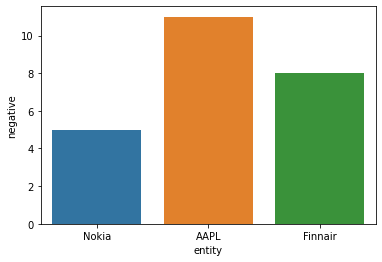

In [122]:
sns.barplot(x='entity', y='negative', data=total_values)

explicação bonita aqui

<AxesSubplot:xlabel='entity', ylabel='positive'>

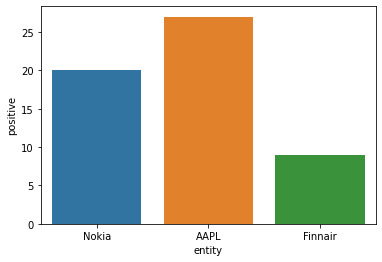

In [123]:
sns.barplot(x='entity', y='positive', data=total_values)

explicação bonita aqui